Import Library 
---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from math import sqrt

import warnings
warnings.simplefilter("ignore")

Load Dataset
---

In [2]:
data_cust = pd.read_csv('Case Study - Customer.csv', delimiter=';')
data_prod = pd.read_csv('Case Study - Product.csv', delimiter=';')
data_store = pd.read_csv('Case Study - Store1.csv', delimiter=';')
data_trx = pd.read_csv('Case Study - Transaction.csv', delimiter=';')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df_cust = data_cust.copy()
df_prod = data_prod.copy()
df_store = data_store.copy()
df_trx = data_trx.copy()

In [5]:
df_cust.shape, df_prod.shape, df_store.shape, df_store.shape, df_trx.shape

((447, 5), (10, 3), (14, 6), (14, 6), (5020, 8))

Data Cleaning
---

Tabel Customer

In [6]:
df_cust.head(3)

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"


In [7]:
#ubah tanda koma (,) dengan titik (.)
df_cust['Income'] = df_cust['Income'].replace('[,]', '.', regex=True).astype(float)

In [8]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      447 non-null    int64  
 1   Age             447 non-null    int64  
 2   Gender          447 non-null    int64  
 3   Marital Status  444 non-null    object 
 4   Income          447 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 17.6+ KB


In [9]:
df_cust.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [10]:
#karena null value sedikit, maka akan di drop
df_cust=df_cust.dropna(subset='Marital Status')
df_cust.isna().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    0
Income            0
dtype: int64

In [11]:
df_cust.duplicated().sum()

0

Tabel Produk

In [12]:
df_prod.head(3)

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500


In [13]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [14]:
df_prod.duplicated().sum()

0

Tabel Store

In [15]:
df_store.head(3)

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666
1,2,Prima Kelapa Dua,Prima,Modern Trade,-6.914864,107.608238
2,3,Prima Kota,Prima,Modern Trade,-7.797068,110.370529


In [16]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   StoreID     14 non-null     int64  
 1   StoreName   14 non-null     object 
 2   GroupStore  14 non-null     object 
 3   Type        14 non-null     object 
 4   Latitude    14 non-null     float64
 5   Longitude   14 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 800.0+ bytes


In [17]:
df_store.duplicated().sum()

0

Tabel Transaksi

In [18]:
df_trx.head(3)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4


In [19]:
df_trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


In [20]:
#ubah dtype date
df_trx['Date'] = pd.to_datetime(df_trx['Date'])


In [21]:
#cek data duplikat pada value 'TransactionID'
value_counts = df_trx['TransactionID'].value_counts()
duplicates = value_counts[value_counts > 1]

print(duplicates)

TR71313    3
TR42197    2
TR90402    2
TR74019    2
TR49649    2
          ..
TR2135     2
TR49903    2
TR99533    2
TR36057    2
TR49304    2
Name: TransactionID, Length: 111, dtype: int64


In [22]:
#cek salah satu value yang memiliki duplikat
df_trx[df_trx['TransactionID'] == 'TR42197']

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
1574,TR42197,181,2022-04-23,P5,4200,4,16800,12
3711,TR42197,24,2022-09-26,P8,16000,2,32000,13


In [23]:
# Mengurutkan DataFrame berdasarkan kolom "date" secara menurun (descending)
df_trx.sort_values(by='Date', ascending=False, inplace=True)

# Menghapus duplikat berdasarkan kolom "transaction id", hanya mempertahankan yang terbaru
df_trx.drop_duplicates(subset='TransactionID', keep='first', inplace=True)


In [24]:
value_counts = df_trx['TransactionID'].value_counts()
duplicates = value_counts[value_counts > 1]

print(duplicates)

Series([], Name: TransactionID, dtype: int64)


In [25]:
df_trx.duplicated().sum()

0

In [26]:
df_trx['Hari'] = df_trx['Date'].dt.day
df_trx['Bulan'] = df_trx['Date'].dt.month

In [27]:
df_trx.sample(3)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Hari,Bulan
3153,TR31792,3,2022-08-17,P5,4200,4,16800,13,17,8
3462,TR1318,369,2022-10-09,P6,18000,1,18000,7,9,10
731,TR47197,272,2022-02-23,P10,15000,5,75000,2,23,2


Menggabungkan semua tabel
---

In [28]:
df_merge = pd.merge(df_trx, df_cust, on=['CustomerID'])
df_merge = pd.merge(df_merge, df_prod.drop(columns= ['Price']), on=['ProductID'])
df_merge = pd.merge(df_merge, df_store, on=['StoreID'])

In [29]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Hari,Bulan,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR85684,55,2022-12-31,P8,16000,1,16000,6,31,12,34,1,Married,8.44,Oat,Lingga,Lingga,Modern Trade,-5.135399,119.42379
1,TR29093,232,2022-09-07,P8,16000,3,48000,6,7,9,62,0,Married,7.32,Oat,Lingga,Lingga,Modern Trade,-5.135399,119.42379
2,TR48254,195,2022-08-28,P8,16000,1,16000,6,28,8,31,1,Married,10.91,Oat,Lingga,Lingga,Modern Trade,-5.135399,119.42379
3,TR23475,128,2022-11-11,P8,16000,3,48000,6,11,11,0,1,Married,6.77,Oat,Lingga,Lingga,Modern Trade,-5.135399,119.42379
4,TR33420,296,2022-06-06,P8,16000,3,48000,6,6,6,38,1,Single,3.18,Oat,Lingga,Lingga,Modern Trade,-5.135399,119.42379


In [30]:
#df_merge.to_excel('kalbe_table_base.xlsx')

Forecasting Data Preparation
---

In [31]:
df_forecast =  df_merge.groupby('Date').agg({
    'Qty' : 'sum'
}).reset_index()

In [32]:
df_forecast

,Date,Qty
0,2022-01-01,47
1,2022-01-02,45
2,2022-01-03,67
3,2022-01-04,98
4,2022-01-05,57
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,40


In [33]:
# Ubah indeks DataFrame menjadi kolom 'date'
df_forecast.set_index('Date', inplace=True)

Check Stationarity
--

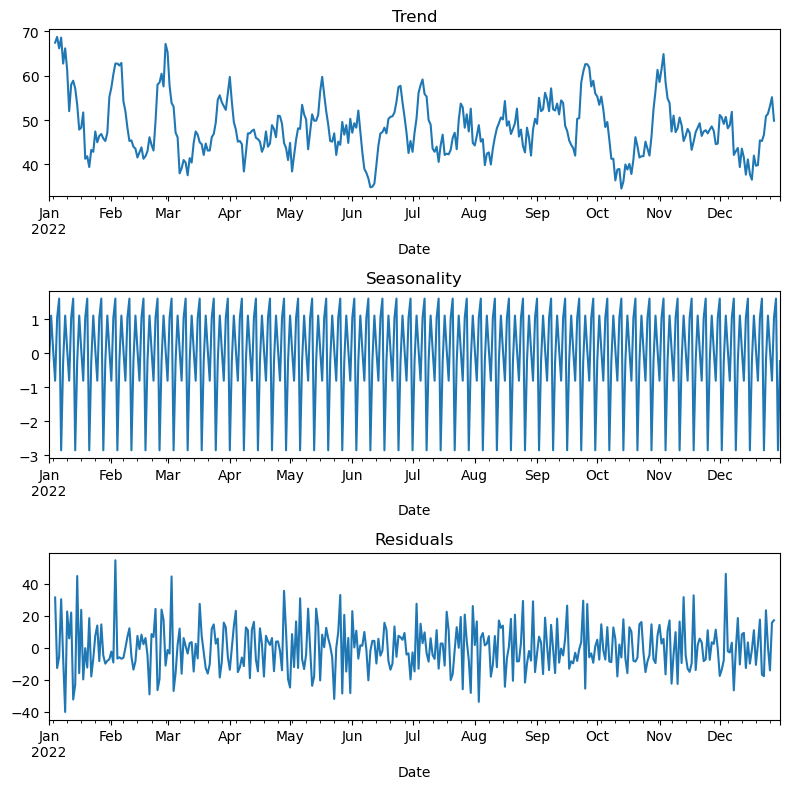

In [34]:
#Addressing Seasonality

decomposed = seasonal_decompose(df_forecast)
plt.figure(figsize=(8,8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

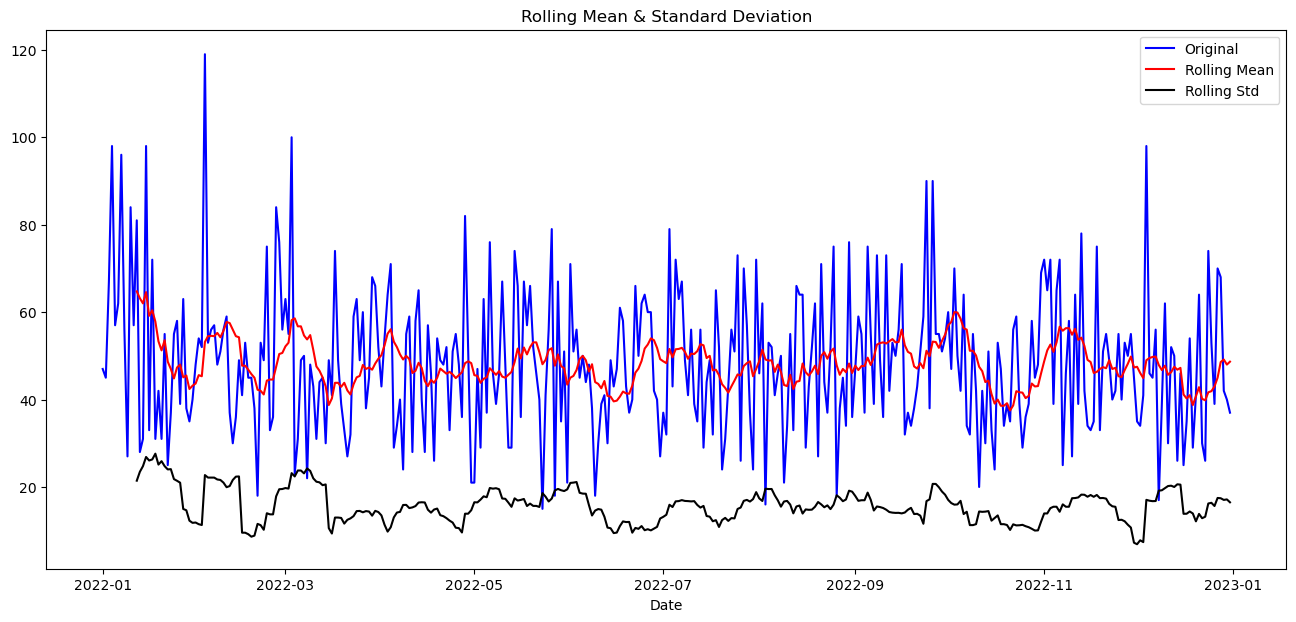

In [35]:
# Rolling statistics

rollmean = df_forecast.rolling(12).mean()
rollstd = df_forecast.rolling(12).std()

# Membuat gambar dan subplot
plt.figure(figsize=(16,7))

# Plot rolling statistics
plt.plot(df_forecast.index, df_forecast, color='blue', label='Original')
plt.plot(rollmean.index, rollmean, color='red', label='Rolling Mean')
plt.plot(rollstd.index, rollstd, color='black', label='Rolling Std')

# Menambahkan legenda dan judul
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

# Mengatur label sumbu x sebagai tanggal
plt.xlabel('Date')

# Menampilkan plot
plt.show()


In [36]:
#Dickey Fuller Test

df_test = adfuller(df_forecast['Qty'])
adf = df_test[0]
pval = df_test[1]

print('ADF Statistics : ', adf)
print('P Value : ', pval)
print('Critical Values:')
for key, value in df_test[4].items():
    print(f'   {key}, {value}')

ADF Statistics :  -19.38238850972903
P Value :  0.0
Critical Values:
   1%, -3.4484434475193777
   5%, -2.869513170510808
   10%, -2.571017574266393


ARIMA model
--

Split Data
--

In [37]:
#split data menjadi data train dan data test
cut_off= round(df_forecast.shape[0] * 0.9)
df_train = df_forecast[:cut_off]
df_test = df_forecast[cut_off:]
df_train.shape, df_test.shape

((328, 1), (37, 1))

In [38]:
df_train

,Qty
Date,
2022-01-01,47
2022-01-02,45
2022-01-03,67
2022-01-04,98
2022-01-05,57
...,...
2022-11-20,51
2022-11-21,55
2022-11-22,49


In [39]:
df_test

,Qty
Date,
2022-11-25,55
2022-11-26,40
2022-11-27,53
2022-11-28,50
2022-11-29,55
2022-11-30,45
2022-12-01,35
2022-12-02,34
2022-12-03,41


In [40]:
#plt.figure(figsize=(20,5))
#sns.lineplot(data= df_train, x= df_train['Date'], y= df_train['Qty']);
#sns.lineplot(data= df_test, x= df_test['Date'], y= df_test['Qty']);

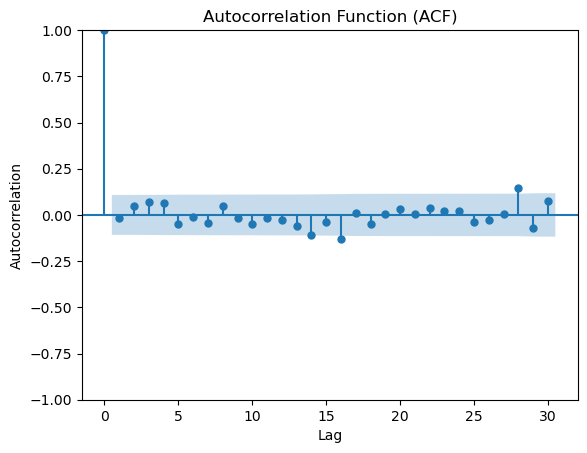

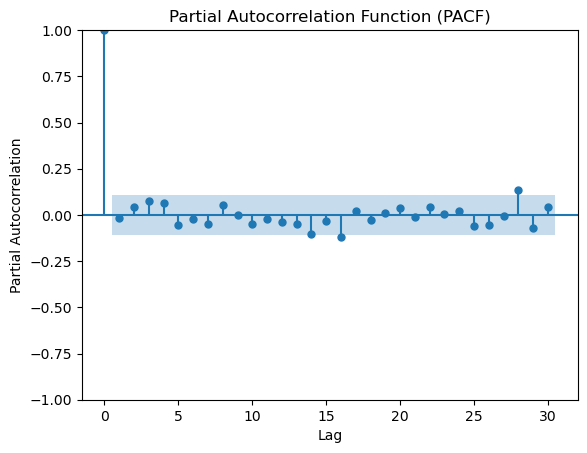

In [41]:
# Plot ACF dengan default method
plot_acf(df_train['Qty'], lags=30)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF dengan ywm method
plot_pacf(df_train['Qty'], lags=30, method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

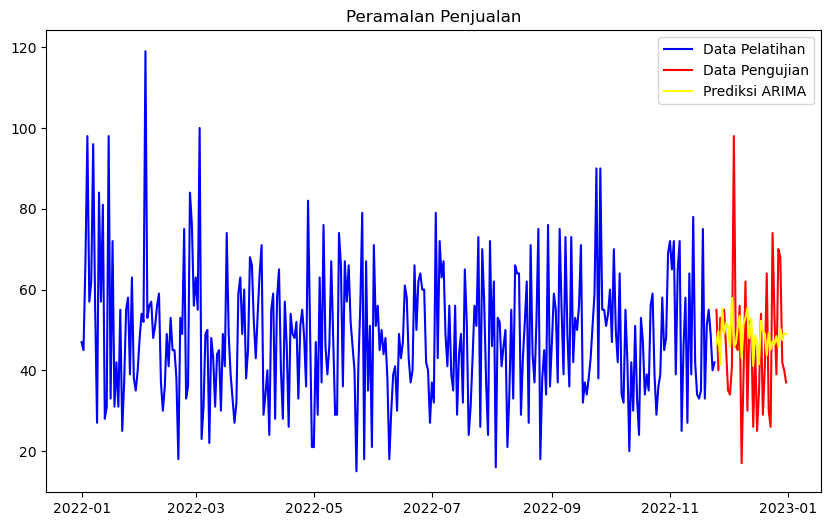

In [42]:
# ARIMA Order (p, d, q)
order = (40, 2, 1)

# Membuat model ARIMA dengan data pelatihan
arima_model = ARIMA(df_train['Qty'], order=order)
arima_model = arima_model.fit()

# Mendapatkan peramalan untuk data pengujian
get_forecast = arima_model.get_forecast(steps=len(df_test))
forecast = get_forecast.conf_int()
forecast['predictions'] = arima_model.predict(start=forecast.index[0], end=forecast.index[-1])

# Menyesuaikan indeks hasil peramalan dengan indeks data pengujian
forecast.index = df_test.index
forecast_pred = forecast['predictions']

# Visualisasi hasil
plt.figure(figsize=(10, 6))
plt.plot(df_train.index, df_train['Qty'], color='blue', label='Data Pelatihan')
plt.plot(df_test.index, df_test['Qty'], color='red', label='Data Pengujian')
plt.plot(forecast_pred, color='yellow', label='Prediksi ARIMA')
plt.title('Peramalan Penjualan')
plt.legend()
plt.show()


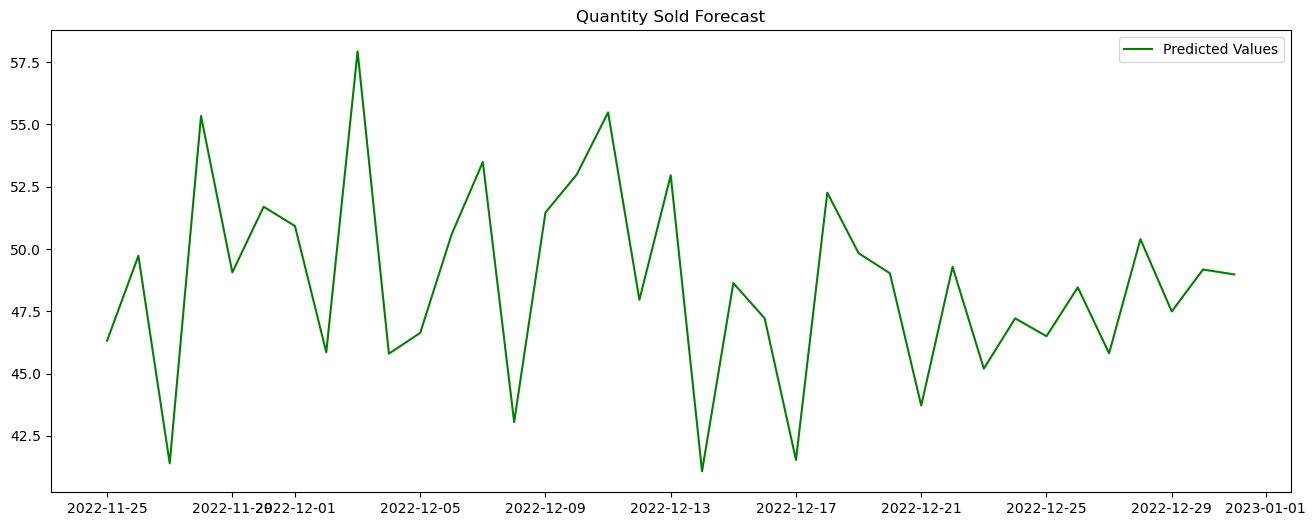

In [43]:
plt.figure(figsize=(16, 6))
plt.plot(forecast_pred, color='green', label='Predicted Values')
plt.title('Estimated Quantity Sold')
plt.legend()
plt.show()

In [46]:
mean_qty = int(round(forecast_pred).mean())
print(f"Mean quantity sold: {mean_qty}")

Mean quantity sold: 48


In [47]:
sales_by_product = df_merge.groupby(['ProductID', 'Product Name', 'Date'])[['Qty']].sum()
sales_by_product = sales_by_product.reset_index()

forecast_dataframe = pd.DataFrame()

for product_name, group in sales_by_product.groupby('Product Name'):
    forecast_df_dum = group[['Date', 'Qty']]
    forecast_df_dum = forecast_df_dum.groupby('Date')[['Qty']].sum().reindex(pd.date_range(start='2022-01-01', end='2022-12-31'), fill_value=0)

    model = ARIMA(forecast_df_dum['Qty'], order=(40, 2, 1))
    model_fit = model.fit()
    forecast_period = df_test.shape[0]

    forecast = model_fit.forecast(steps=forecast_period)
    forecast_dataframe[product_name] = forecast.values

forecast_dataframe.head()

,Cashew,Cheese Stick,Choco Bar,Coffee Candy,Crackers,Ginger Candy,Oat,Potato Chip,Thai Tea,Yoghurt
0,0.493558,7.614363,6.777178,3.240895,4.659515,4.914800,2.228722,4.329370,6.816634,6.463536
1,1.985865,3.856930,6.579613,3.174628,6.610636,7.041043,2.483070,4.653181,3.822161,4.536280
2,2.080769,3.205926,4.645759,4.393005,6.525647,8.104067,2.469802,2.362995,9.662083,4.217999
3,2.659657,7.044609,6.107209,5.060412,3.808654,6.021710,2.567547,2.590308,9.131032,4.253584
4,1.232614,6.123326,-1.721610,5.284316,7.199388,6.508368,1.792207,3.066972,7.499239,3.707555


In [50]:
mean_qty_sold = round(forecast_dataframe).mean()
print(f"Mean Quantity sold:{mean_qty_sold}")

Mean Quantity sold:Cashew           1.918919
Cheese Stick     5.432432
Choco Bar        3.810811
Coffee Candy     5.378378
Crackers         4.972973
Ginger Candy     6.459459
Oat              2.459459
Potato Chip      3.810811
Thai Tea         6.513514
Yoghurt          3.945946
dtype: float64


In [51]:
predicted_values = forecast_pred
actual_values = df_test

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 16.3341206480994
MAE: 12.989476592736835


Clustering
---

In [52]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Hari,Bulan,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR85684,55,2022-12-31,P8,16000,1,16000,6,31,12,34,1,Married,8.44,Oat,Lingga,Lingga,Modern Trade,-5.135399,119.42379
1,TR29093,232,2022-09-07,P8,16000,3,48000,6,7,9,62,0,Married,7.32,Oat,Lingga,Lingga,Modern Trade,-5.135399,119.42379
2,TR48254,195,2022-08-28,P8,16000,1,16000,6,28,8,31,1,Married,10.91,Oat,Lingga,Lingga,Modern Trade,-5.135399,119.42379
3,TR23475,128,2022-11-11,P8,16000,3,48000,6,11,11,0,1,Married,6.77,Oat,Lingga,Lingga,Modern Trade,-5.135399,119.42379
4,TR33420,296,2022-06-06,P8,16000,3,48000,6,6,6,38,1,Single,3.18,Oat,Lingga,Lingga,Modern Trade,-5.135399,119.42379


In [53]:
df_cluster = df_merge.groupby(['CustomerID']).agg({
    'TransactionID' : 'count',
    'Qty' : 'sum',
    'TotalAmount' : 'sum'
}).reset_index()

In [54]:
df_cluster.head()

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,12,56,382300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600


In [55]:
X = df_cluster.iloc[:, -2:]

num_clusters = 3

k_means = KMeans(n_clusters=num_clusters, n_init=12)
k_means.fit(X)
labels = k_means.labels_

df_cluster["Labels"] = labels
df_cluster.head()
     

,CustomerID,TransactionID,Qty,TotalAmount,Labels
0,1,17,60,623300,1
1,2,12,56,382300,0
2,3,15,56,446200,1
3,4,10,46,302500,0
4,5,7,27,268600,2


In [56]:
df_cluster.groupby('Labels').mean()

,CustomerID,TransactionID,Qty,TotalAmount
Labels,,,,
0,212.497537,11.133005,40.413793,358339.901478
1,209.790000,14.900000,56.390000,529813.000000
2,249.241135,7.900709,27.255319,220122.695035


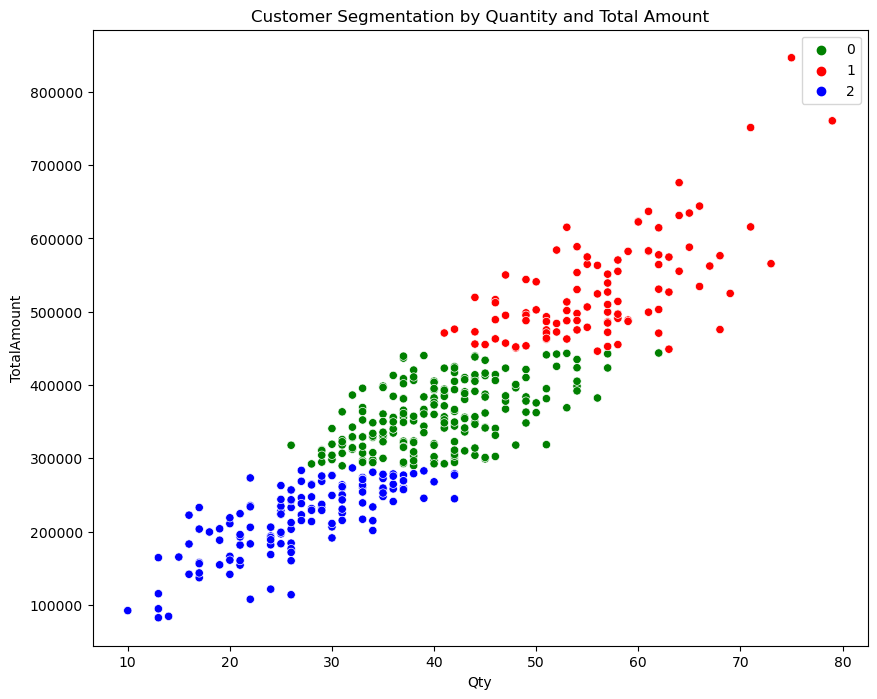

In [57]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df_cluster['Qty'], y=df_cluster['TotalAmount'], hue=df_cluster['Labels'], palette=['g', 'r', 'b'])
plt.title('Customer Segmentation by Quantity and Total Amount')
plt.legend()
plt.show()

In [58]:
silhouette_score(X, labels)

0.548041714805897